# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.
9. SGD performed much faster, but not very accurate
9. Interpreted Logistic Model - only 4 variables worth keeping
10. Reduced logistic model performs slightly better than full and much simpler

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [2]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Read in preprocessed data from previous assignment

In [3]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [4]:
print(cc_data.info())
print()
print(cc_data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [5]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [6]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [7]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [8]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 10
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [9]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [10]:
def grid_searcher(model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(cc_data_Xs,cc_data_target)
    return clf

# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(model, params, cv_object)

In [11]:
#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.81125
The best parameters of model is:  {'C': 1000, 'penalty': 'l1', 'class_weight': None}


# The grid search reveals 
# [Insert something here]
format smaller when complete

### Find coefficients 

In [12]:
def full_classify(y, X, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    acc_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)
        acc_list.append(mt.accuracy_score(y[test_indices],y_hat))

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat))
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list, acc_list

In [13]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled, logit_acc_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.804666666667
confusion matrix
 [[4505  126]
 [1046  323]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4631
          1       0.72      0.24      0.36      1369

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.604365347448


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.807166666667
confusion matrix
 [[4554  119]
 [1038  289]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.89      4673
          1       0.71      0.22      0.33      1327

avg / total       0.79      0.81      0.76      6000

ROC Score 
 0.596159518251


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.810666666667
confusion matrix
 [[4543  122]
 [1014  321]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4665
          1       0.72      0.24      0.36      1335

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.607148620494


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.801166666667
confusion matrix
 [[4503  138]
 [1055  304]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4641
          1       0.69      0.22      0.34      1359

avg / total       0.78      0.80      0.76      6000

ROC Score 
 0.596979460828


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.813833333333
confusion matrix
 [[4562  129]
 [ 988  321]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4691
          1       0.71      0.25      0.36      1309

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.608862947904


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.811333333333
confusion matrix
 [[4548  143]
 [ 989  320]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4691
          1       0.69      0.24      0.36      1309

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.606988757791


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.81
confusion matrix
 [[4531  114]
 [1026  329]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4645
          1       0.74      0.24      0.37      1355

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.609130954603


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.8145
confusion matrix
 [[4571  113]
 [1000  316]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4684
          1       0.74      0.24      0.36      1316

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.607998450393


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.813666666667
confusion matrix
 [[4539  133]
 [ 985  343]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4672
          1       0.72      0.26      0.38      1328

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.614907833388


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.816
confusion matrix
 [[4609  115]
 [ 989  287]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4724
          1       0.71      0.22      0.34      1276

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.600288926817
done. It took 8.036459684371948 seconds.


### Intrepretting weights of Logistic Model using Scaled Data

In [14]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def analysis(coef_list, acc_list, labels):
    # Below averages the output of the cross validations
    coef_list_avg = np.array(np.mean(coef_list, axis=0 ))
    acc_list_avg = np.mean(acc_list)

    print("The average accuracy score is: ", acc_list_avg)

    # Sanity check to make sure the column name list is the same length as the coefficients
    print("Coefficients and column names same length: " + str(len(coef_list_avg.T)==len(labels)))
    print()

    # print coefficients with label
    zip_vars = zip(coef_list_avg.T,labels) # combine attributes
    for coef, name in zip_vars:
        print(name, 'has weight of', coef[0]) # now print them out

    weights = pd.Series(coef_list_avg[0],index=labels)
    weights.plot(kind='bar')
    plt.show()

The average accuracy score is:  0.8103
Coefficients and column names same length: True

EDUCATION has weight of -0.00420505552082
PAY_0_Sept has weight of 0.648452198052
PAY_2_Aug has weight of 0.102841457199
PAY_3_July has weight of 0.0888451183413
PAY_4_June has weight of 0.025931061438
PAY_5_May has weight of 0.0560964834372
PAY_6_April has weight of 0.00349478678145
BILL_AMT1_Sept has weight of -0.443203326902
BILL_AMT2_Aug has weight of 0.212029469965
BILL_AMT3_July has weight of 0.0627847515896
BILL_AMT4_June has weight of -0.00658986122006
BILL_AMT5_May has weight of 0.0102254415188
BILL_AMT6_April has weight of 0.0449334874585
PAY_AMT1_Sept has weight of -0.227663316571
PAY_AMT2_Aug has weight of -0.225046361025
PAY_AMT3_July has weight of -0.0697876982158
PAY_AMT4_June has weight of -0.0587871011468
PAY_AMT5_May has weight of -0.0569123703715
PAY_AMT6_April has weight of -0.0462698050583
AGE_range has weight of 0.0384525937899
LIMIT_BAL_range has weight of -0.0325262564546
isM

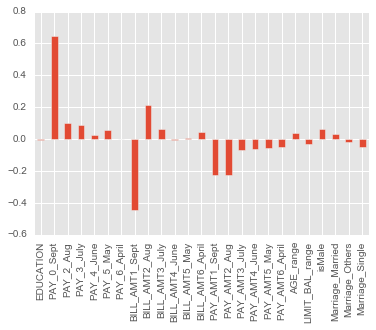

In [15]:
analysis(logit_coef_scaled, logit_acc_scaled, cc_data_Xs_names)

The average accuracy score is:  0.8103
Coefficients and column names same length: True

EDUCATION has weight of -0.00420505552082
PAY_0_Sept has weight of 0.648452198052
PAY_2_Aug has weight of 0.102841457199
PAY_3_July has weight of 0.0888451183413
PAY_4_June has weight of 0.025931061438
PAY_5_May has weight of 0.0560964834372
PAY_6_April has weight of 0.00349478678145
BILL_AMT1_Sept has weight of -0.443203326902
BILL_AMT2_Aug has weight of 0.212029469965
BILL_AMT3_July has weight of 0.0627847515896
BILL_AMT4_June has weight of -0.00658986122006
BILL_AMT5_May has weight of 0.0102254415188
BILL_AMT6_April has weight of 0.0449334874585
PAY_AMT1_Sept has weight of -0.227663316571
PAY_AMT2_Aug has weight of -0.225046361025
PAY_AMT3_July has weight of -0.0697876982158
PAY_AMT4_June has weight of -0.0587871011468
PAY_AMT5_May has weight of -0.0569123703715
PAY_AMT6_April has weight of -0.0462698050583
AGE_range has weight of 0.0384525937899
LIMIT_BAL_range has weight of -0.0325262564546
isM

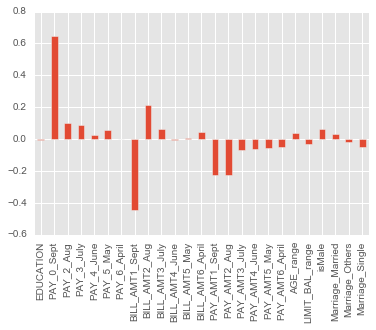

In [16]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


# Below averages the output of the cross validations
logit_coef_scaled_avg = np.array(np.mean(logit_coef_scaled, axis=0 ))
logit_acc_scaled_avg = np.mean(logit_acc_scaled)

print("The average accuracy score is: ", logit_acc_scaled_avg)

# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(logit_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(logit_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

weights = pd.Series(logit_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()

### Logitic Interpretation of Full Model

PAY_0_Sept and BILL_AMT1_Sept are the two strongest indicators of default. Pay_0_Sept and Bill_AMT1_Sept have high weights, >0.4 and <-0.4 respectively, compared to the other coefficients and are significant to the model. Secondarily, PAY_AMT1_Sept and PAY_AMT2_Aug have a similar strength of indicators. PAY_0_Sept indicates how many months late is the payment, so it is logical that as this increases the log odd off default would increase as well. BILL_AMT1 indicates the amount billed, and the weighting suggest counter to logic that bigger bills tended to default less frequently. Due to the high multicollinearity of the BILL_AMT variables, as discovered previously in project 1, this weighting might not be trustable.

### Reduced Logistic Model

In [17]:
cc_data_Xs_logit_reduced = cc_data_processed[[
 'PAY_0_Sept',
 'BILL_AMT1_Sept',
 'PAY_AMT1_Sept',
 'PAY_AMT2_Aug',
]].values

# Column names for labeling
cc_data_Xs_names_lr = cc_data_processed[[
 'PAY_0_Sept',
 'BILL_AMT1_Sept',
 'PAY_AMT1_Sept',
 'PAY_AMT2_Aug',
]].columns

In [18]:
logit_coef_scaled_lr, logit_acc_scaled_lr = full_classify(cc_data_target, cc_data_Xs_logit_reduced, cv_object, 
                                                          logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

SCALED DATA

====Iteration 0  ====
accuracy 0.815166666667
confusion matrix
 [[4542  142]
 [ 967  349]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4684
          1       0.71      0.27      0.39      1316

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.617440799566
SCALED DATA

====Iteration 1  ====
accuracy 0.818166666667
confusion matrix
 [[4574  155]
 [ 936  335]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4729
          1       0.68      0.26      0.38      1271

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.615397752522
SCALED DATA

====Iteration 2  ====
accuracy 0.812666666667
confusion matrix
 [[4501  157]
 [ 967  375]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4658
          1       0.70   

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.sh

The average accuracy score is:  0.811666666667
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.8106615056
BILL_AMT1_Sept has weight of -0.121431018486
PAY_AMT1_Sept has weight of -0.22886289227
PAY_AMT2_Aug has weight of -0.263812429097


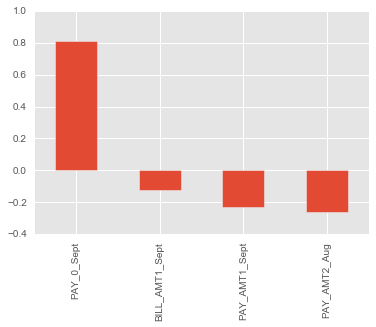

In [19]:
# Below averages the coeficients of the cross validations
logit_coef_scaled_avg_lr = np.array(np.mean( logit_coef_scaled_lr, axis=0 ))
logit_acc_scaled_avg_lr = np.mean(logit_acc_scaled_lr)

print("The average accuracy score is: ", logit_acc_scaled_avg_lr)

# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(logit_coef_scaled_avg_lr.T)==len(cc_data_Xs_names_lr)))
print()

# print coefficients with label
zip_vars = zip(logit_coef_scaled_avg_lr.T,cc_data_Xs_names_lr) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# Graph the coeficients to find the standout features
weights = pd.Series(logit_coef_scaled_avg_lr[0],index=cc_data_Xs_names_lr)
weights.plot(kind='bar')
plt.show()

# [Enter comparison of full model to reduced model here]

## Support Vector Machine - Using SGDClassifier

In [ ]:
# Create New Cross Validation object
cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=1, learning_rate='optimal')

# Parameteres to search on:
alpha_values = [.1,1,10,100,1000]
params = {'penalty':('l1','l2'), 
          'alpha':alpha_values, 
          'fit_intercept':(True, False)}

# Run grid search with cv_object
sgd_clf = grid_searcher(model, params, cv_object)

In [ ]:
# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

In [ ]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled, sgd_acc_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, sgd_clf.best_estimator_, scale=True)

# model = SVC(C=0.05, kernel='linear', degree=3, gamma='auto')
# full_classify(cc_data_target, cc_data_Xs, cv_object, model, scale=True)

In [ ]:
# Below averages the coeficients of the cross validations
sgd_coef_scaled_avg = np.array(np.mean( sgd_coef_scaled, axis=0 ))
sgd_acc_scaled_avg = np.mean(sgd_acc_scaled)

print("The average accuracy score is: ", sgd_acc_scaled_avg)

# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(sgd_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(sgd_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

# Graph the coeficients to find the standout features
weights = pd.Series(sgd_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()